# Library Usage in Seattle, 2005-2020

## Modeling

The data that is the basis for this project is the [Checkouts by Title (Physical Items)](https://data.seattle.gov/Community/Checkouts-By-Title-Physical-Items-/5src-czff) dataset from [Seattle Open Data](https://data.seattle.gov/). It was downloaded on December 15, 2020. Using API calls in [this notebook](0x_api_calls.ipynb), I obtained the rest of the data for the year 2020.

In this notebook, I will be working only with the item checkout counts data created in the [previous (EDA) notebook](02_eda.ipynb). There are 2 versions of this data, one that is missing values for various dates, and one in which those missing values have been imputed (again this process is detailed in the [previous notebook](02_eda.ipynb)). I will mostly be working with the imputed data, but may try using Facebook Prophet in conjunction with the unimputed dataset, since it can handle missing values.

I will look at seasonality, trends, and stationarity in order to create time series models and forecasts for future library use, as well as measure the impact that the COVID-19 pandemic has had on Seattle's libraries.


## Table of contents

1. [Import required packages](#Import-required-packages)
2. [Load data](#Load-data)
3. [Check for stationarity](#Check-for-stationarity)
4. [Train-test split](#Train-test-split)
5. [Dummy model](#Dummy-model)
6. [SARIMAX](#SARIMAX)

### Import required packages

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

In [1]:
# standard dataframe packages
import pandas as pd; pd.set_option('display.max_columns', 50)
import numpy as np
import itertools

# graphing packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# time-related packages
import datetime
import holidays

# statistical packages
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# modeling packages
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# saving packages
import gzip
import pickle

# custom functions
from functions.data_cleaning import *

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # may want to use the following:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import TimeDistributed
# from keras.layers import Flatten
# from keras.layers import Dropout
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

### Load data

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

- I'll load in two datasets:
    - One with the "missing" dates (generally either holidays and possibly dates when the data collection was somehow compromised) replaced with imputed values (refer to the [previous notebook](02_eda.ipynb)).
    - One with missing values, which can potentially be used for a model like Facebook Prophet.

In [2]:
# load imputed data
df_imputed = pd.read_pickle('data/seattle_lib_counts_imputed.pkl', compression='gzip')

# load unimputed data
df_unimputed = pd.read_pickle('data/seattle_lib_counts_unimputed.pkl', compression='gzip')

# check shapes
df_imputed.shape, df_unimputed.shape

((5742, 34), (5742, 34))

In [3]:
# take a look
df_imputed.head()

total_checkouts  missing_title  missing_subjects  \
2005-04-13          16471.0          212.0             664.0   
2005-04-14          10358.0          123.0             541.0   
2005-04-15          12896.0          179.0             508.0   
2005-04-16           1358.0            7.0              56.0   
2005-04-17           4555.0           80.0             232.0   

            format_group_Equipment  format_group_Media  format_group_Other  \
2005-04-13                     1.0              6397.0                32.0   
2005-04-14                     1.0              4015.0                75.0   
2005-04-15                     0.0              5351.0                51.0   
2005-04-16                     0.0               552.0                 0.0   
2005-04-17                     0.0              1555.0                 8.0   

            format_group_Print  format_subgroup_Art  \
2005-04-13             10041.0                  0.0   
2005-04-14              6267.0                  0.0   
2005-04-15              7494.0                  0.0   
2005-04-16               806.0                  0.0   
2005-04-17              2992.0                  0.0   

            format_subgroup_Audio Disc  format_subgroup_Audio Tape  \
2005-04-13                      1874.0                        63.0   
2005-04-14                      1245.0                        31.0   
2005-04-15                      1462.0                        54.0   
2005-04-16                       175.0                         8.0   
2005-04-17                       499.0                        10.0   

            format_subgroup_Audiobook Disc  format_subgroup_Audiobook Tape  \
2005-04-13                           217.0                           308.0   
2005-04-14                           164.0                           156.0   
2005-04-15                           187.0                           239.0   
2005-04-16                            31.0                            23.0   
2005-04-17                            47.0                            96.0   

            format_subgroup_Book  format_subgroup_Data Disc  \
2005-04-13                9970.0                       10.0   
2005-04-14                6225.0                        7.0   
2005-04-15                7452.0                       12.0   
2005-04-16                 802.0                        1.0   
2005-04-17                2946.0                        9.0   

            format_subgroup_Document  format_subgroup_Film  \
2005-04-13                       0.0                   0.0   
2005-04-14                       0.0                   0.0   
2005-04-15                       0.0                   0.0   
2005-04-16                       0.0                   0.0   
2005-04-17                       0.0                   0.0   

            format_subgroup_Folder  format_subgroup_Kit  \
2005-04-13                     8.0                 97.0   
2005-04-14                     8.0                 85.0   
2005-04-15                     4.0                 80.0   
2005-04-16                     2.0                  9.0   
2005-04-17                     7.0                 19.0   

            format_subgroup_Music Score  format_subgroup_Periodical  \
2005-04-13                         40.0                         0.0   
2005-04-14                         28.0                         0.0   
2005-04-15                         35.0                         0.0   
2005-04-16                          1.0                         0.0   
2005-04-17                         27.0                         0.0   

            format_subgroup_Video Disc  format_subgroup_Video Tape  \
2005-04-13                      1950.0                      1878.0   
2005-04-14                      1212.0                      1115.0   
2005-04-15                      1596.0                      1721.0   
2005-04-16                       142.0                       163.0   
2005-04-17                       395.0               

## Check for stationarity

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

- Before I can begin modeling, I need to check whether the data is stationary using the Dickey-Fuller test. If it isn't, I'll have to transform it until it, in essence, passes the test.
- I should note that a major goal of this project is to measure the effect that COVID-19 has had on the library system of Seattle, so it probably makes sense to only use pre-pandemic (or more accurately, pre-lockdown) data in the model.
    - Still, I will check for stationarity with many subsets of the data in order to hopefully provide a clearer picture of it.

#### All data

In [5]:
# set target variable
target = df_imputed.total_checkouts

In [6]:
# run dickey-fuller test
d_f_test = adfuller(target)

# convert results to series
d_f_output = pd.Series(d_f_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
d_f_output

Test Statistic                   -1.631459
p-value                           0.466727
#Lags Used                       34.000000
Number of Observations Used    5707.000000
dtype: float64

- The p-value is certainly above an alpha of 0.05, so I fail to reject the null hypothesis, i.e. the data as a whole is not stationary!
- I'll try taking the difference of the data, then run another Dickey-Fuller test.

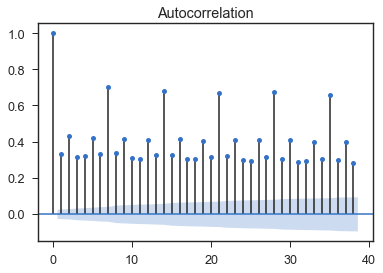

In [7]:
plot_acf(target, alpha=.05);

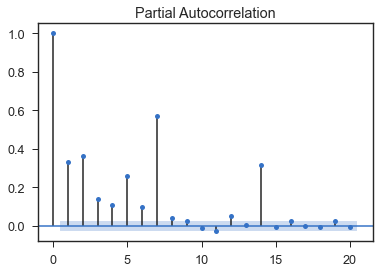

In [8]:
plot_pacf(target, alpha=.05, lags=20);

In [11]:
# get differenced values
diff = target.diff()

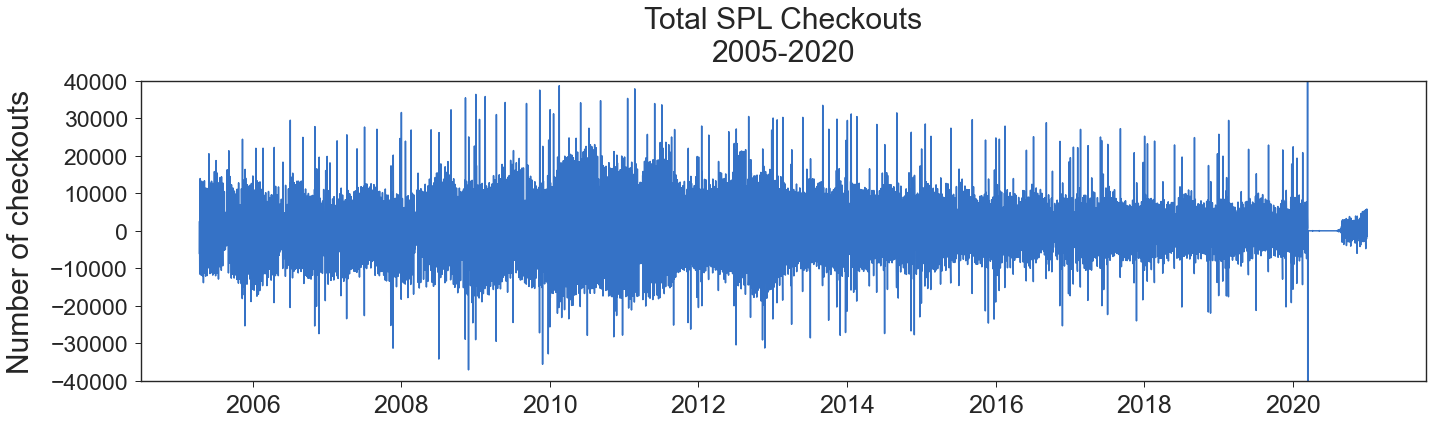

In [12]:
# instantiate figure
plt.figure(figsize=(20,6))

# prettify plot
plt.title(f'Total SPL Checkouts\n2005-2020', fontsize=30, pad=20)
plt.ylabel('Number of checkouts', fontsize=30, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=23)
plt.ylim(bottom=-40000, top=40000)

# plot
plt.plot(diff)

# prepare to save and display
plt.tight_layout()

# # uncomment to save
plt.savefig('charts/ts_modeling/total_checkouts_differenced_line.png', 
            bbox_inches='tight', transparent=True)

plt.show()

In [13]:
# run dickey-fuller test
d_f_test = adfuller(diff[1:])

# convert results to series
d_f_output = pd.Series(d_f_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
d_f_output

Test Statistic                  -19.924555
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    5706.000000
dtype: float64

- This data is now stationary!
- I'll take a look at autocorrelation and partial autocorrelation, which will help me in any model making later, should I choose to use this pandemic-included data.

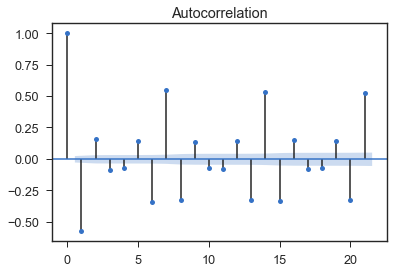

In [19]:
# autocorrelation
plot_acf(diff[1:], alpha=.05, lags=21);

- I'm noticing a weekly correlation, as well as correlation based on whether or not it's a weekend, signified by the two downward-facing lines that are a couple days apart in the above graph.

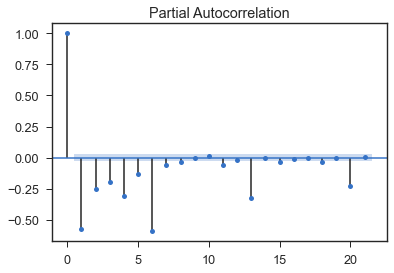

In [20]:
# partial autocorrelation
plot_pacf(diff[1:], alpha=.05, lags=21);

- The weekend trend is far less aparent here, but the weekly correlation remains.

#### Data before March 13

Again, since I most likely want to build this model based on "normal", pre-lockdown data, I'll perform a Dickey-Fuller test on all data before March 13, the date of Seattle's first lockdown.

In [14]:
# subset target data
target = target[:'2020-03-12']

In [22]:
# run dickey-fuller test
d_f_test = adfuller(target)

# convert results to series
d_f_output = pd.Series(d_f_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
d_f_output

Test Statistic                   -3.690726
p-value                           0.004246
#Lags Used                       28.000000
Number of Observations Used    5419.000000
dtype: float64


- This data appears stationary from the outset! as the p-value is below an alpha of .05.

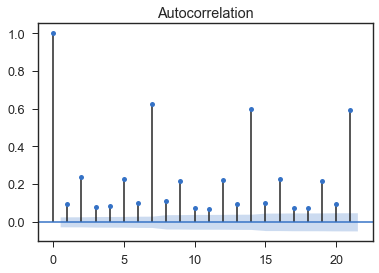

In [21]:
# autocorrelation
plot_acf(target, alpha=.05, lags=21);

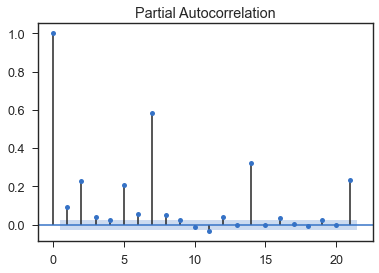

In [22]:
# partial autocorrelation
plot_pacf(target, alpha=.05, lags=21);

- Unsurprisingly there is still a weekly correlation, and the weekend correlation appears stronger in this "normal" data.

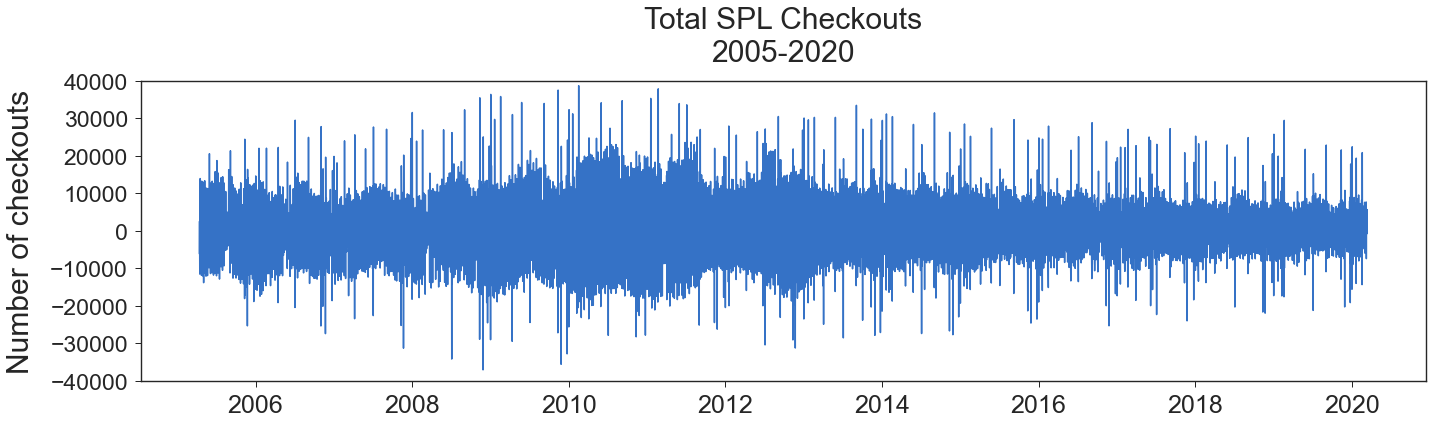

In [23]:
# get differenced values
diff = target.diff()

# instantiate figure
plt.figure(figsize=(20,6))

# prettify plot
plt.title(f'Total SPL Checkouts\n2005-2020', fontsize=30, pad=20)
plt.ylabel('Number of checkouts', fontsize=30, labelpad=15)
plt.xticks(fontsize=25)
plt.yticks(fontsize=23)
plt.ylim(bottom=-40000, top=40000)

# plot
plt.plot(diff)

# prepare to save and display
plt.tight_layout()

# # uncomment to save
plt.savefig('charts/ts_modeling/total_checkouts_differenced_pre-pandemic_line.png', 
            bbox_inches='tight', transparent=True)

plt.show()

In [24]:
df_test = adfuller(diff[1:])
dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                  -21.792329
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5413.000000
dtype: float64


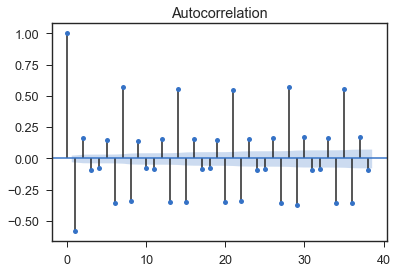

In [28]:
plot_acf(diff[1:], alpha=.05);

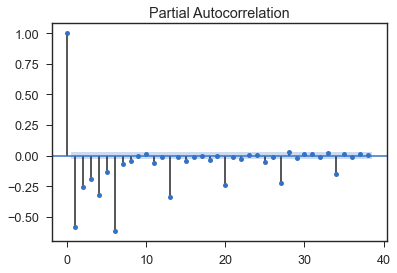

In [29]:
plot_pacf(diff[1:], alpha=.05);

In [4]:
target = df_imputed.total_checkouts['2006-01-01':]

In [5]:
year_groups = target.groupby(pd.Grouper(freq='A'))

In [6]:
for yr, group in year_groups:
    print(len(group[:365]))

365
365
365
365
365
365
365
365
365
365
365
365
365
365
365


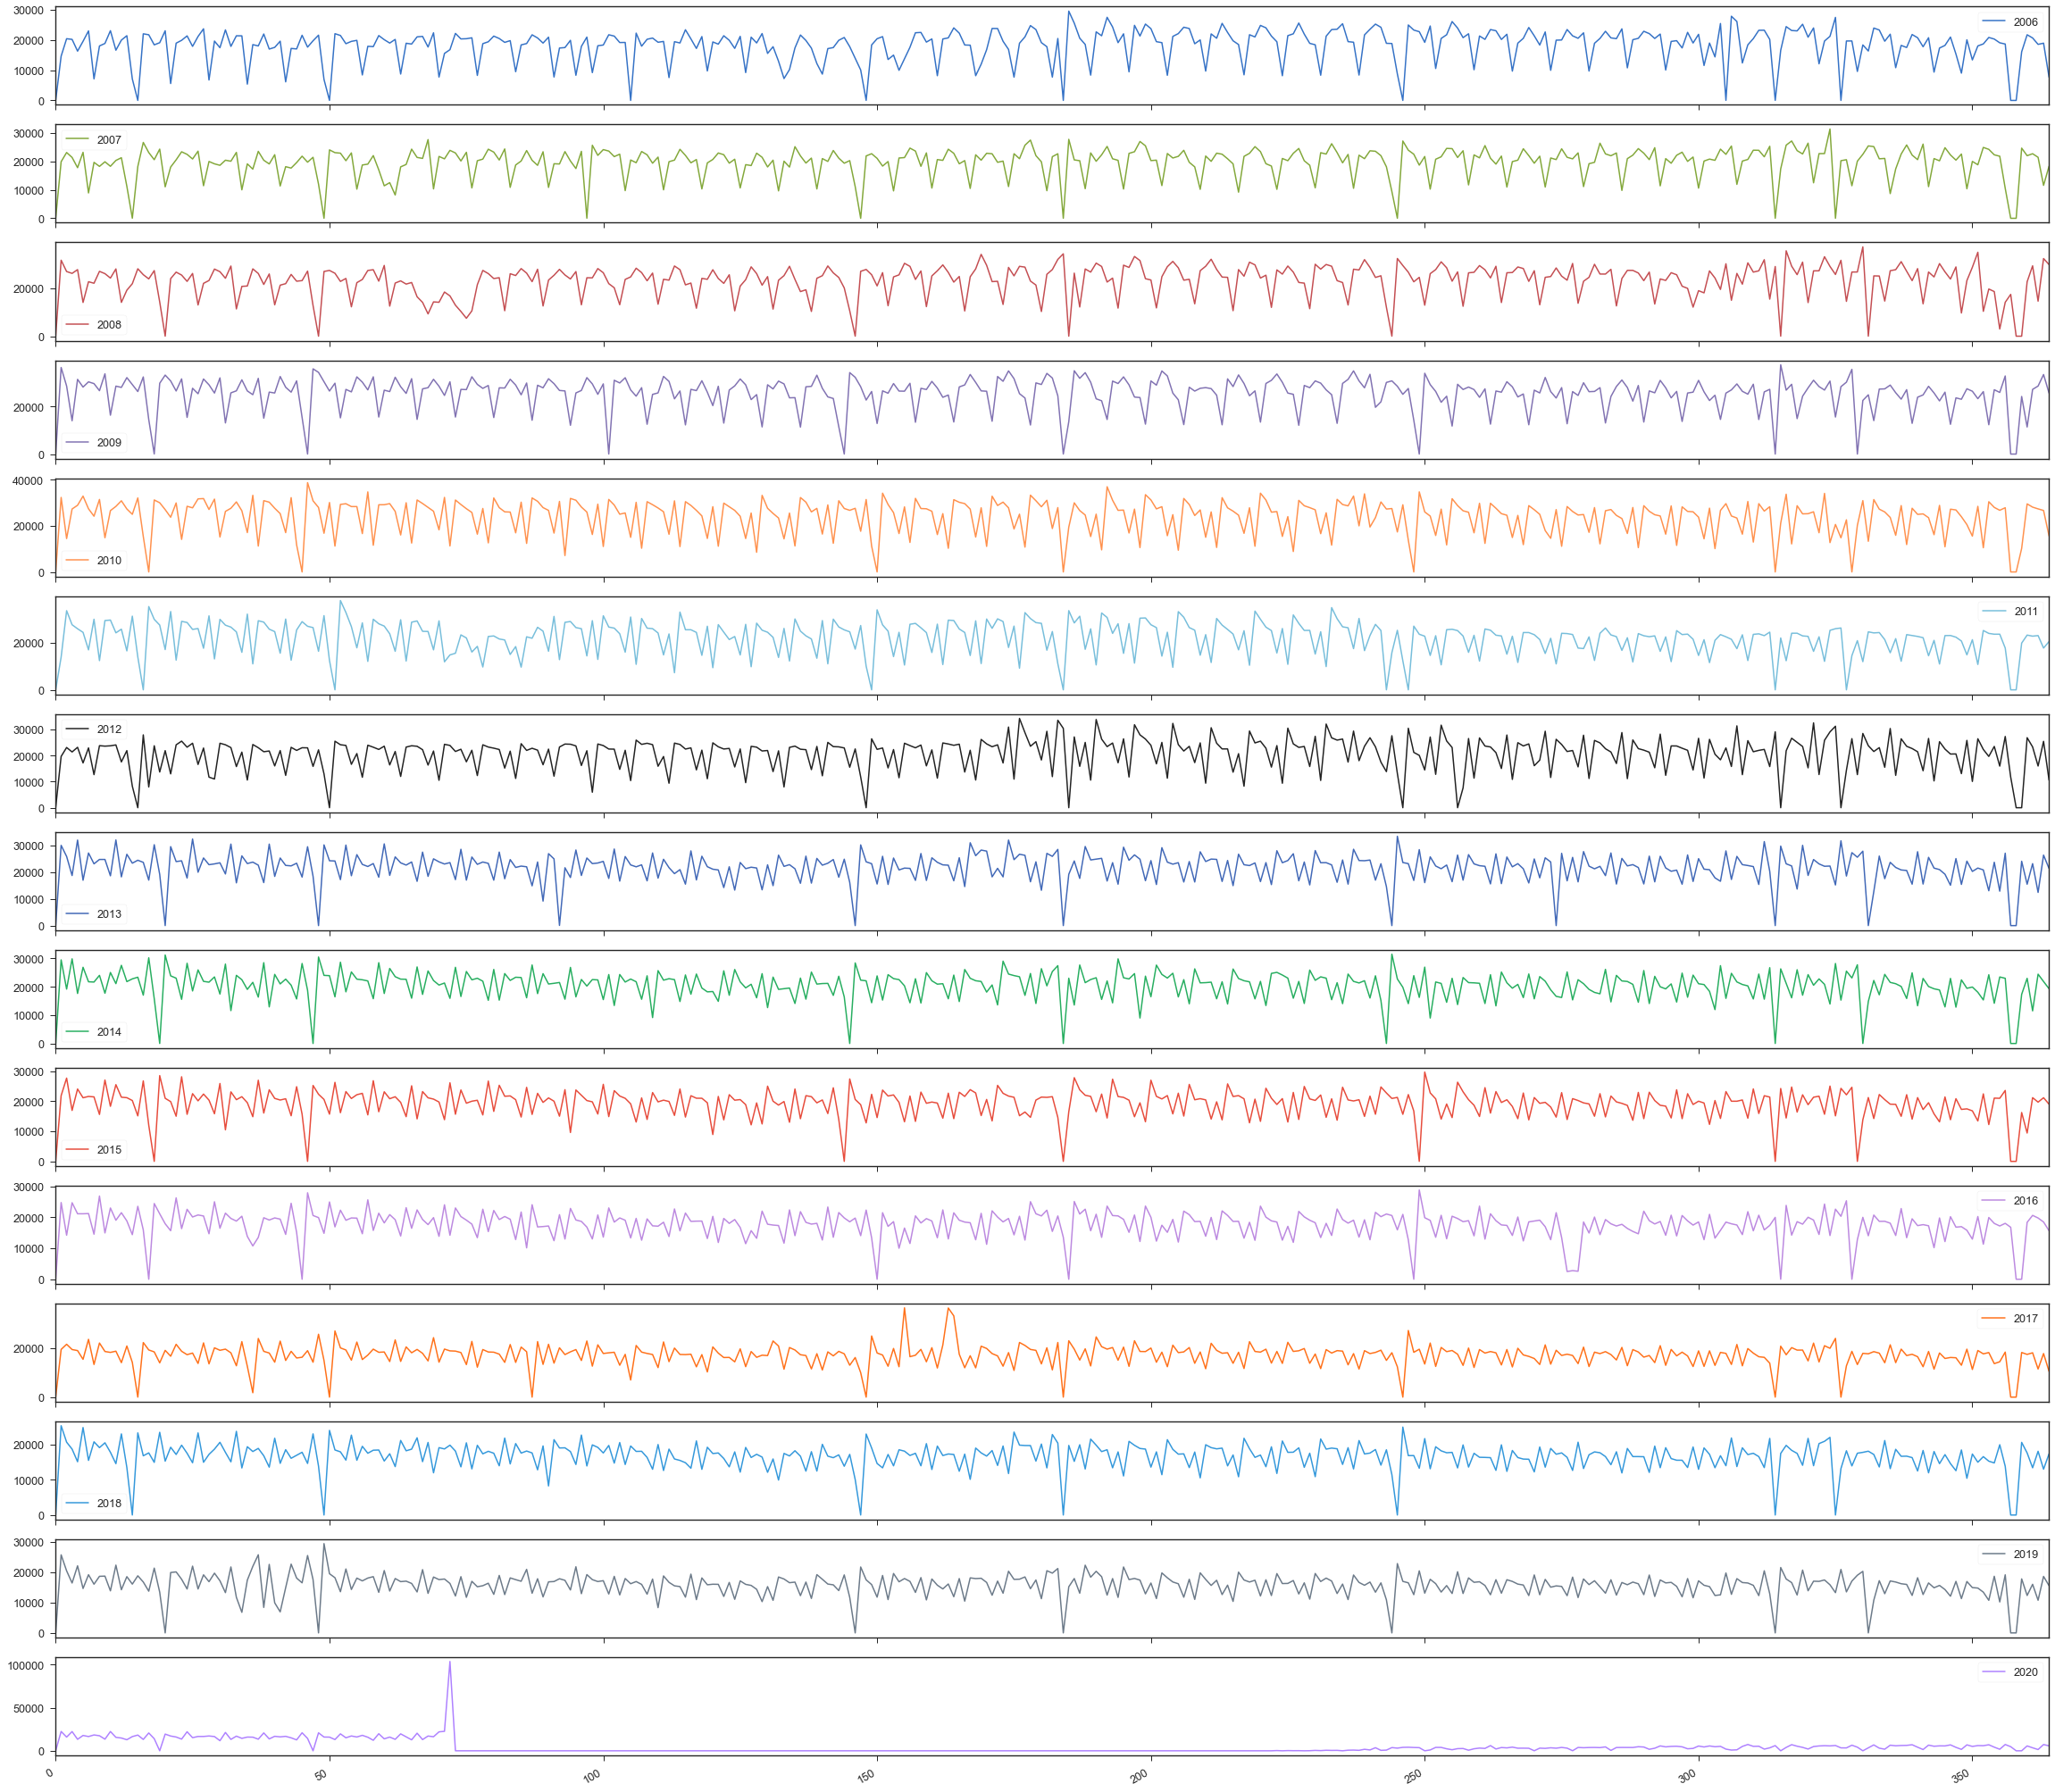

In [7]:
# Create a new DataFrame and store yearly values in columns  
checkouts_annual = pd.DataFrame() 
for yr, group in year_groups:
    checkouts_annual[yr.year] = group[:365].values.ravel()
# Plot the yearly groups as subplots
checkouts_annual.plot(figsize=(40,40), subplots=True, legend=True)
plt.show()

#### At first glance, there appears to be a yearly trend, but I suspect this has more to do with holidays, which I can incorporate into the model.

In [8]:
checkouts_annual

2006     2007     2008     2009     2010     2011     2012     2013  \
0        2.0     12.0     11.0      2.0      1.0      0.0      0.0      0.0   
1    14623.0  19844.0  31556.0  36372.0  32293.0  13881.0  19670.0  30070.0   
2    20380.0  23068.0  26858.0  28590.0  14463.0  33565.0  23096.0  25915.0   
3    20164.0  21344.0  26082.0  13996.0  27280.0  27592.0  21388.0  18758.0   
4    16282.0  17744.0  27648.0  31392.0  28889.0  25900.0  23171.0  32046.0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
360  21684.0  21953.0  22607.0  11376.0  29495.0  23211.0  26854.0  15511.0   
361  20631.0  22642.0  29230.0  27176.0  28086.0  22762.0  23318.0  23218.0   
362  18514.0  21385.0  14544.0  28580.0  27330.0  23016.0  15996.0  12435.0   
363  18910.0  11547.0  32244.0  33422.0  26635.0  17721.0  25460.0  26410.0   
364   7674.0  18261.0  29742.0  25626.0  15600.0  20463.0  10587.0  21419.0   

        2014     2015     2016     2017     2018     2019     2020  
0        2.0      0.0      0.0      0.0      0.0      0.0      0.0  
1    29438.0  21827.0  24763.0  19497.0  25241.0  25739.0  22403.0  
2    19147.0  27646.0  14212.0  21611.0  20595.0  20461.0  15881.0  
3    29807.0  16913.0  24704.0  19453.0  18633.0  16457.0  22293.0  
4    17612.0  24025.0  21140.0  19031.0  15061.0  22114.0  13320.0  
..       ...      ...      ...      ...      ...      ...      ...  
360  22943.0   9414.0  18364.0  17465.0  17551.0  12345.0   5649.0  
361  11486.0  21161.0  20617.0  18125.0  13348.0  16027.0   3471.0  
362  24402.0  19665.0  19774.0  11499.0  18014.0  10764.0   1445.0  
363  21813.0  21130.0  18474.0  17816.0  12960.0  18621.0   7260.0  
364  19285.0  18993.0  15661.0  10534.0  17292.0  15583.0   5739.0  

[365 rows x 15 columns]

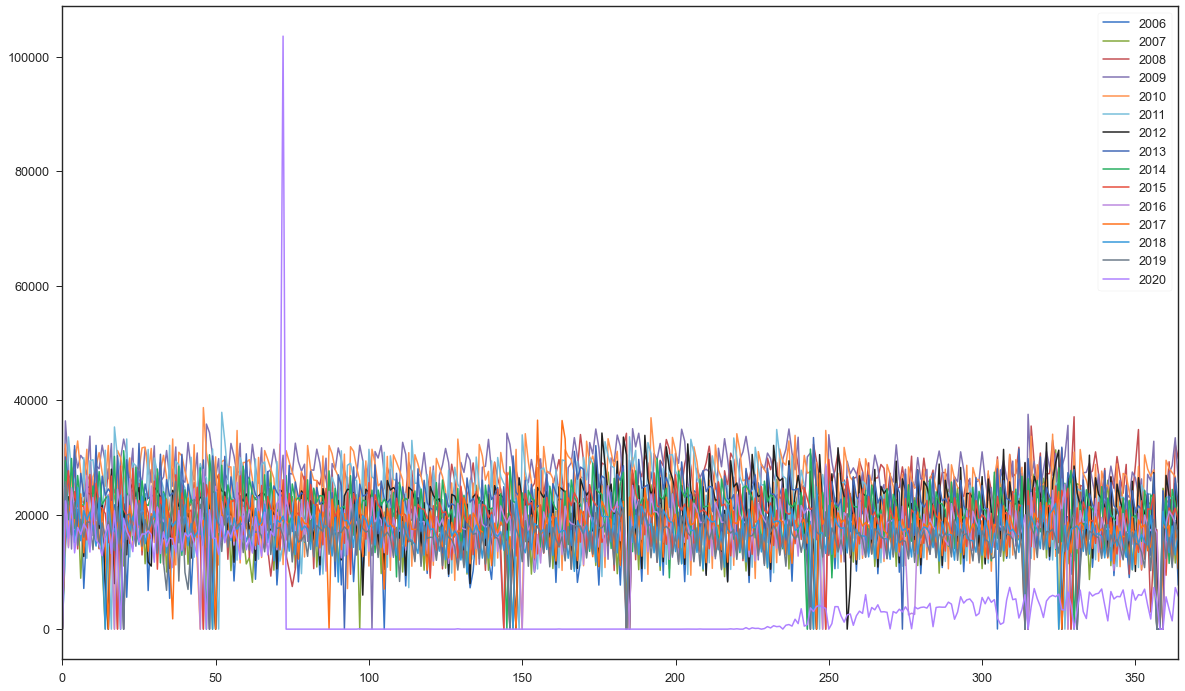

In [9]:
# Plot all years on the same graph
checkouts_annual.plot(figsize = (20,12), subplots=False, legend=True)
plt.show()

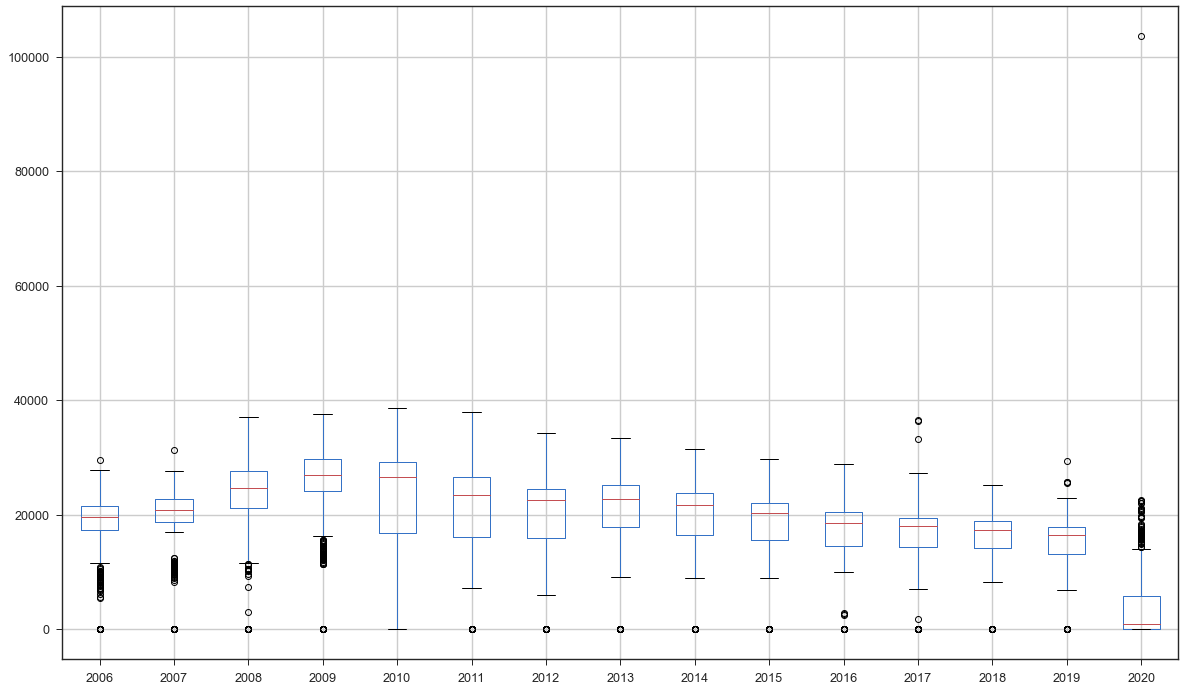

In [10]:
# Plot all years on the same graph
checkouts_annual.boxplot(figsize=(20,12))
plt.show()

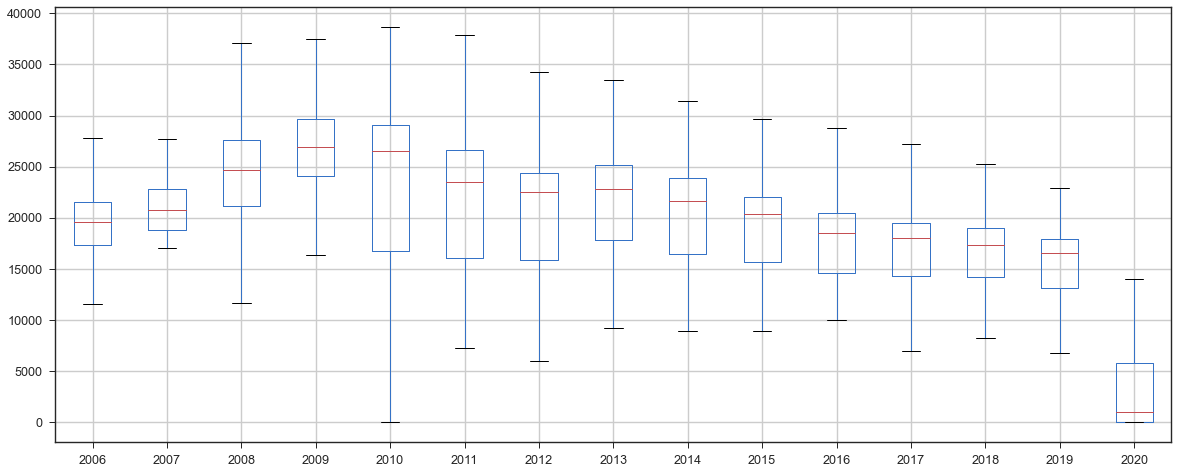

In [11]:
# Plot all years on the same graph
checkouts_annual.boxplot(figsize=(20,8), showfliers=False)
plt.show()

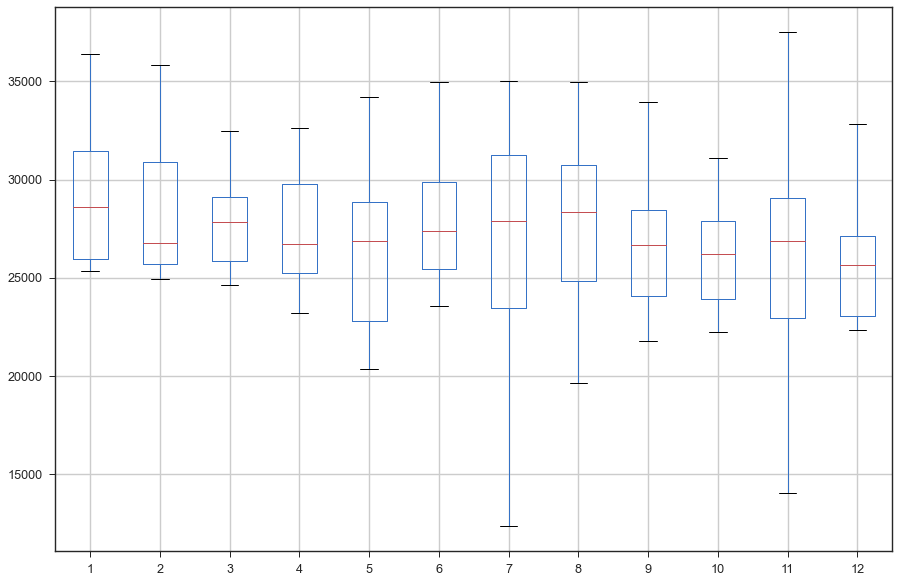

In [12]:
# Use temp_data to extract values for 2009
yr_2009 = target['2009']
# Group observations by month
groups_monthly = yr_2009.groupby(pd.Grouper(freq ='M'))
# Add each month to DataFrame as a column
months_2009 = pd.concat([pd.DataFrame(x[1].values) for x in groups_monthly], axis=1)
months_df = pd.DataFrame(months_2009)
# Set the column names for each month i.e. 1,2,3, .., 12
months_df.columns = range(1,13)
# Plot the box and whiskers plot for each month 
months_df.boxplot(figsize = (15,10), showfliers=False)
plt.show()

In [13]:
X = target.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=21641.195255, mean2=16205.495071
variance1=51220546.252021, variance2=52267441.429968


In [30]:
seasonal_decompose(target)

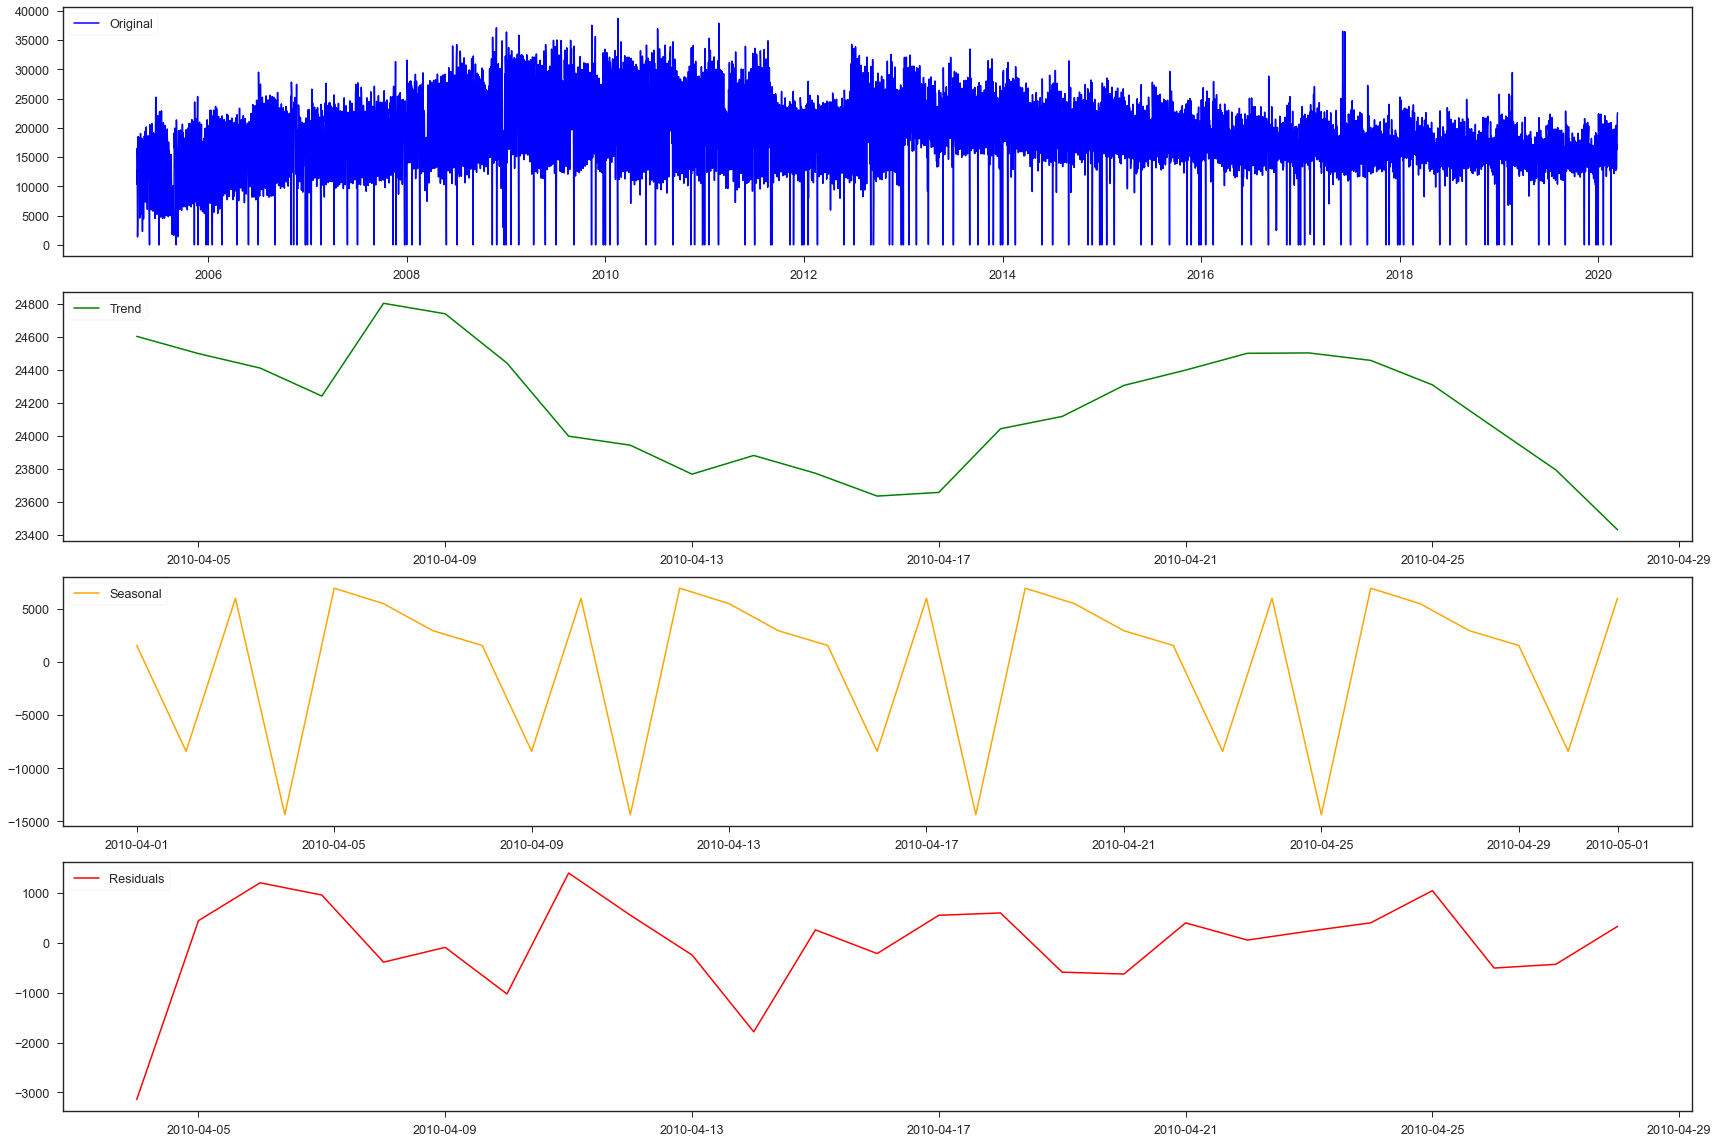

In [31]:
decomposition = seasonal_decompose(target['2010-04-01':'2010-05-01'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

plt.figure(figsize=(24,16))
plt.subplot(411)
plt.plot(target,label='Original',color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label='Trend',color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal',color='orange')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuals,label='Residuals',color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#### There very much appears to be a weekly trend as well

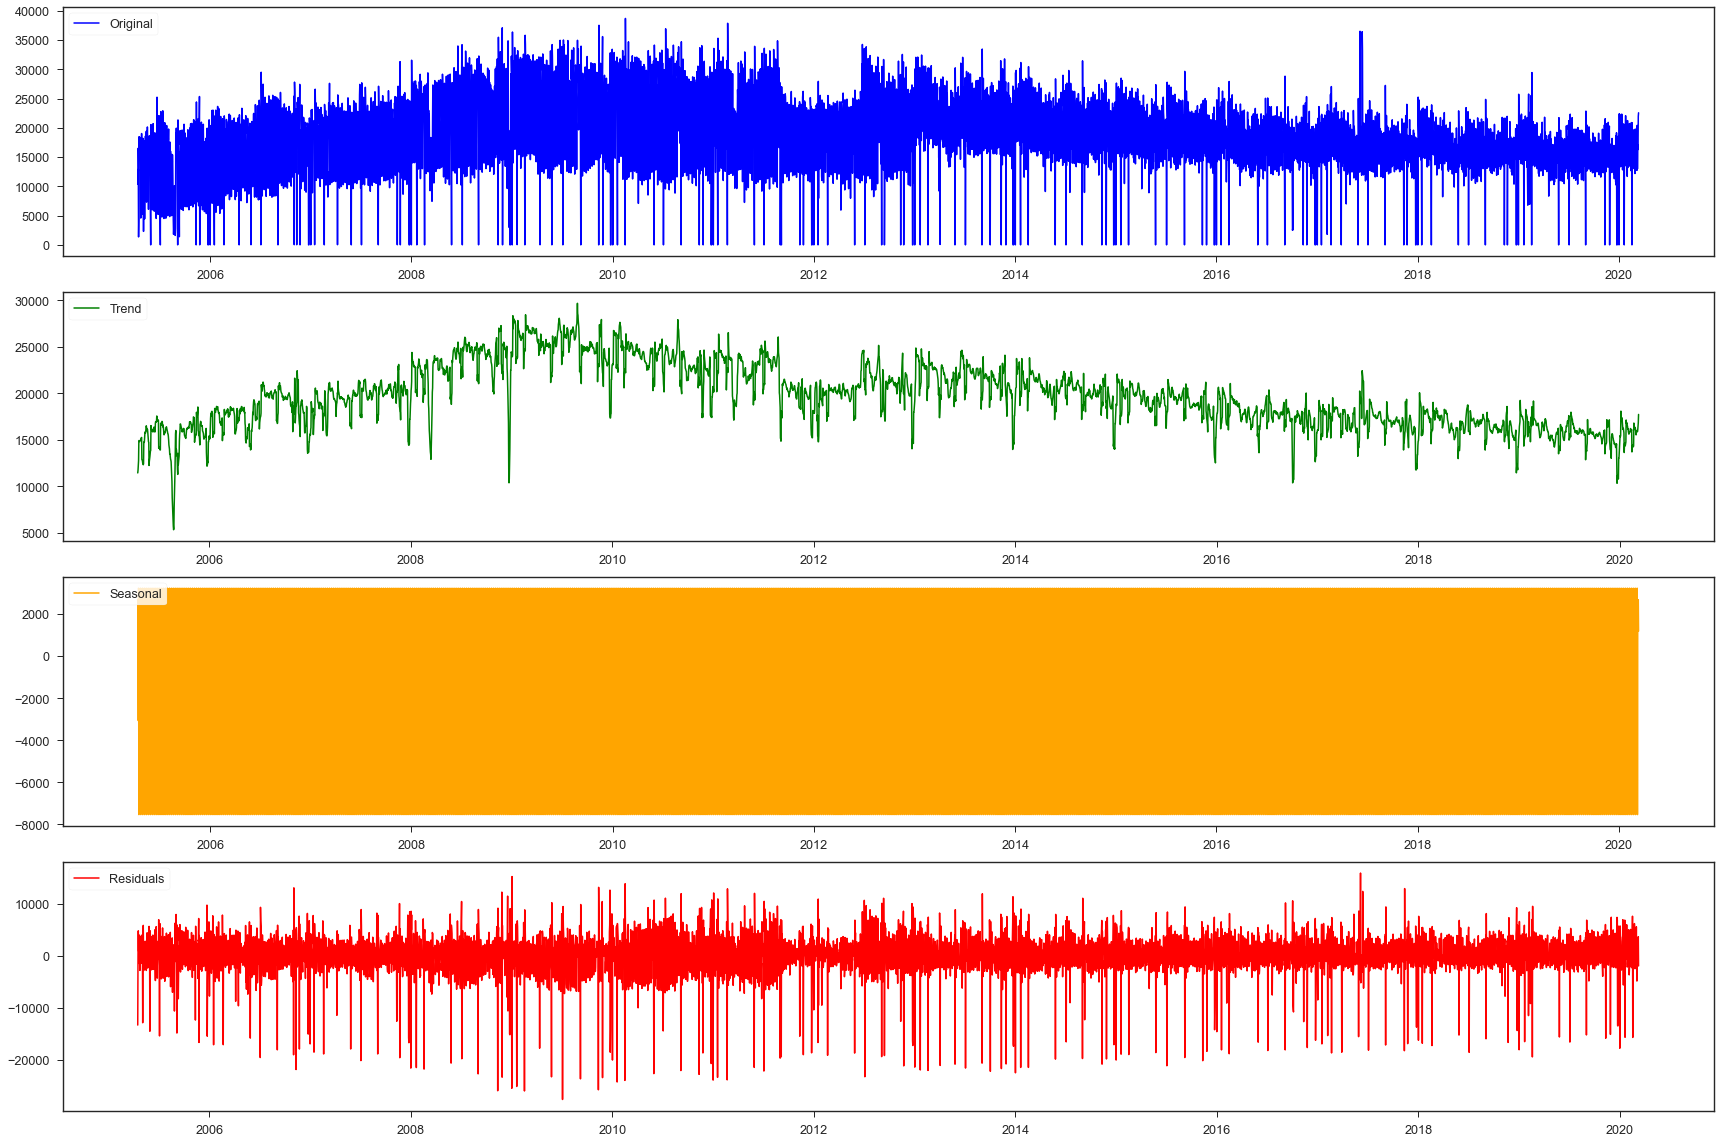

In [32]:
decomposition = seasonal_decompose(target)

trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

plt.figure(figsize=(24,16))
plt.subplot(411)
plt.plot(target,label='Original',color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label='Trend',color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal',color='orange')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuals,label='Residuals',color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [33]:
target = df_imputed.total_checkouts[:'2020-03-12']

# Determine rolling statistics
roll_mean = target.rolling(window=12, center=False).mean()
roll_std = target.rolling(window=12, center=False).std()

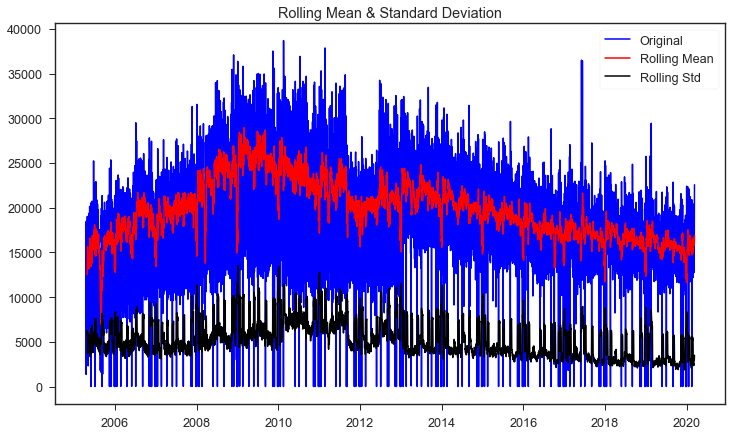

In [34]:
# Plot rolling statistics
fig = plt.figure(figsize=(12,7))
plt.plot(target, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

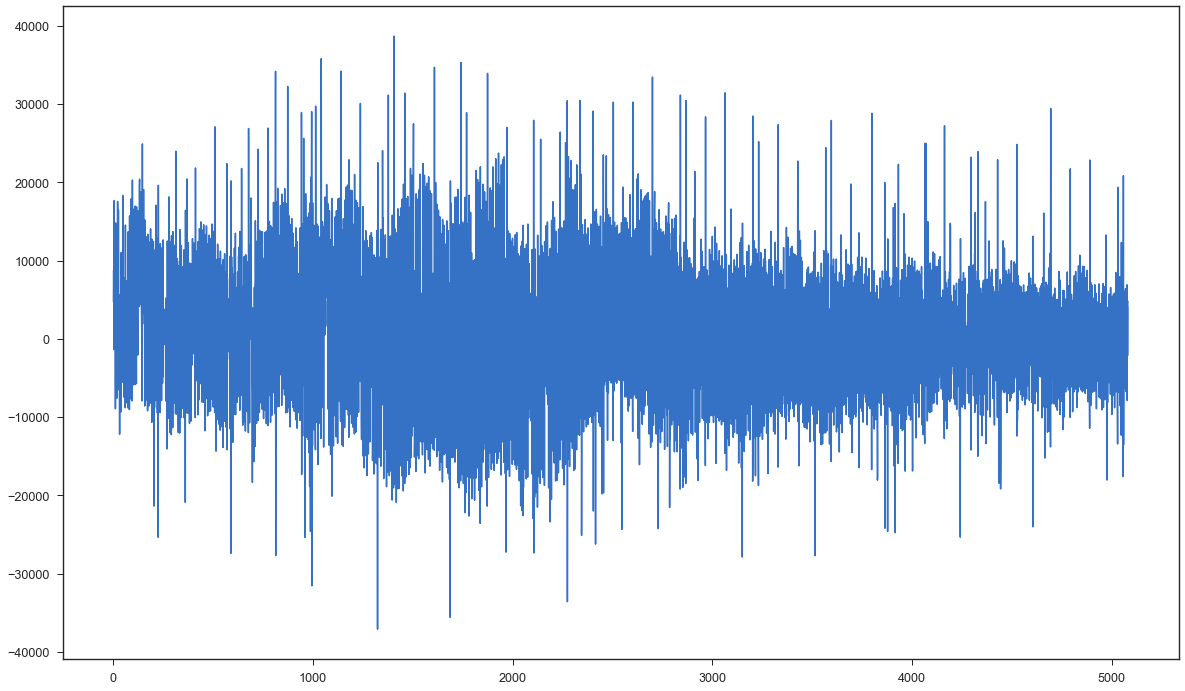

In [35]:
X = target.values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
    value = X[i] - X[i - days_in_year]
    diff.append(value)

plt.figure(figsize=(20,12))
plt.plot(diff)
plt.show()

2005-04-30    13936.222222
2005-05-31    14137.032258
2005-06-30    16641.066667
2005-07-31    15432.032258
2005-08-31    11971.000000
2005-09-30    14858.400000
2005-10-31    15870.451613
2005-11-30    16691.200000
2005-12-31    15175.290323
2006-01-31    16839.483871
2006-02-28    16959.964286
2006-03-31    18298.612903
2006-04-30    17142.366667
Freq: M, Name: total_checkouts, dtype: float64


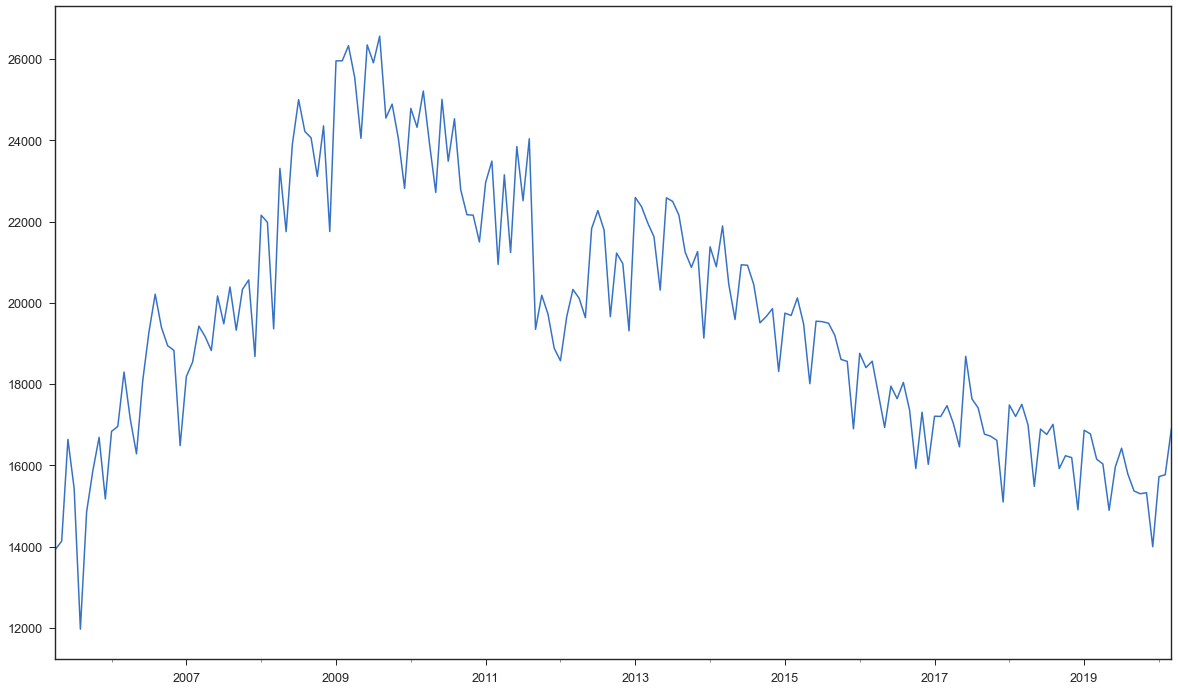

In [36]:
resample = target.resample('M')
monthly_mean = resample.mean()
print(monthly_mean.head(13))

plt.figure(figsize=(20,12))
monthly_mean.plot()
plt.show()

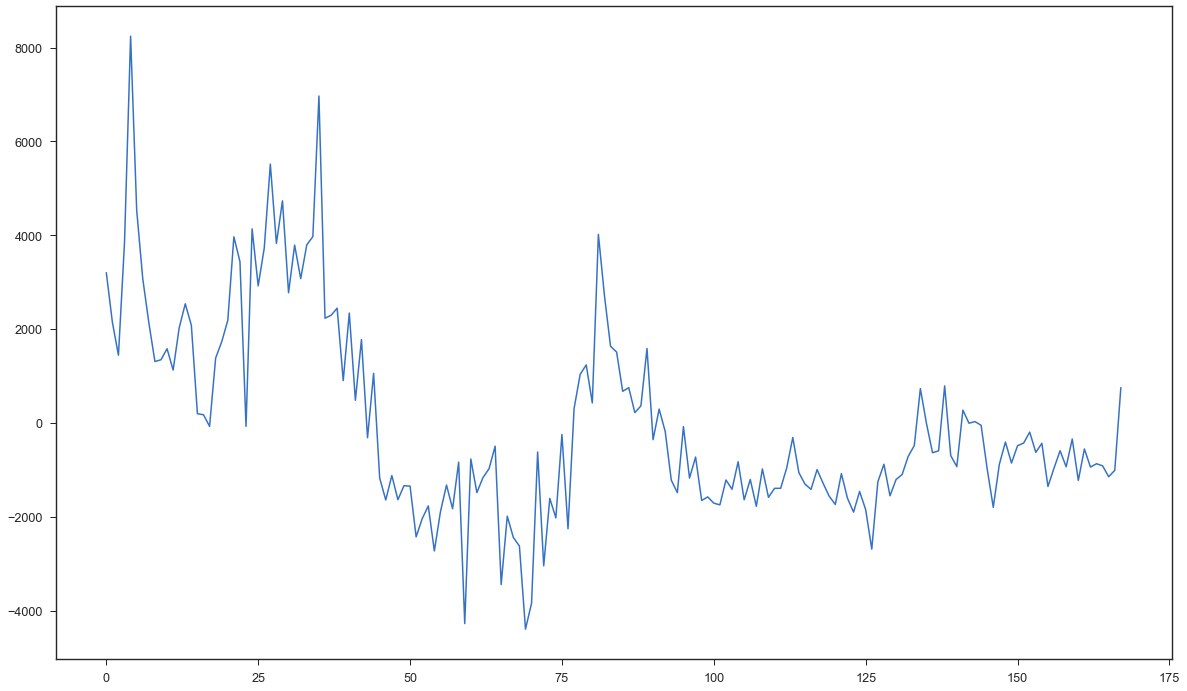

In [37]:
resample = target.resample('M')
monthly_mean = resample.mean()
X = target.values
diff = list()
months_in_year = 12
for i in range(months_in_year, len(monthly_mean)):
    value = monthly_mean[i] - monthly_mean[i - months_in_year]
    diff.append(value)
    
plt.figure(figsize=(20,12))
plt.plot(diff)
plt.show()

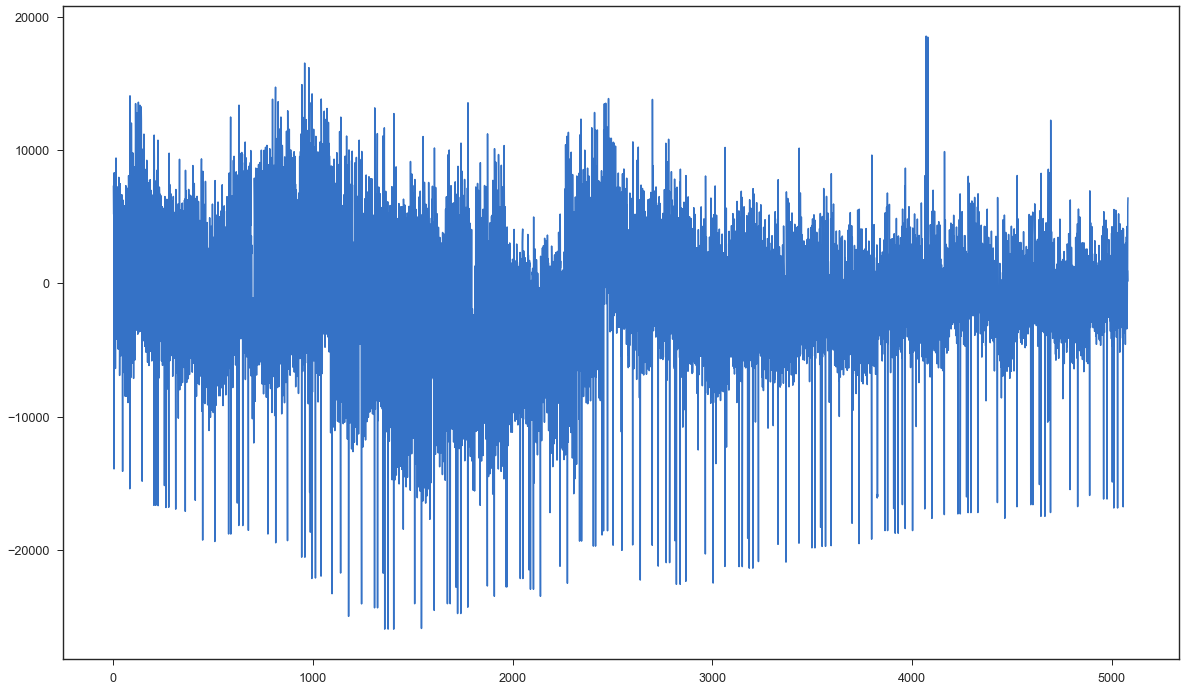

In [38]:
X = target.values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
    month_str = str(target.index[i].year-1)+'-'+str(target.index[i].month)
    month_mean_last_year = target[month_str].mean()
    value = X[i] - month_mean_last_year
    diff.append(value)
    
plt.figure(figsize=(20,12))
plt.plot(diff)
plt.show()

2005-04-17     9127.600000
2005-04-24    14910.285714
2005-05-01    15151.857143
2005-05-08    12371.000000
2005-05-15    15719.857143
2005-05-22    16126.428571
2005-05-29    14707.857143
2005-06-05    13852.571429
2005-06-12    15855.142857
2005-06-19    16094.428571
2005-06-26    17009.142857
2005-07-03    17083.285714
2005-07-10    13904.142857
Freq: W-SUN, Name: total_checkouts, dtype: float64


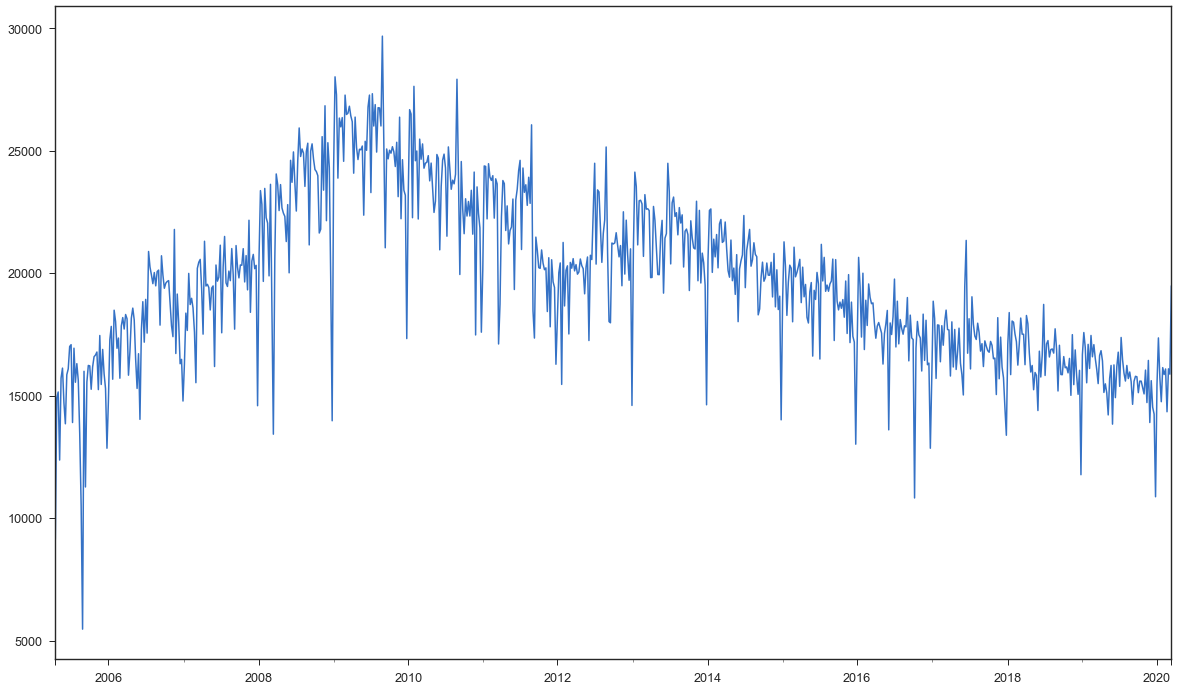

In [39]:
resample = target.resample('W')
weekly_mean = resample.mean()
print(weekly_mean.head(13))

plt.figure(figsize=(20,12))
weekly_mean.plot()
plt.show()

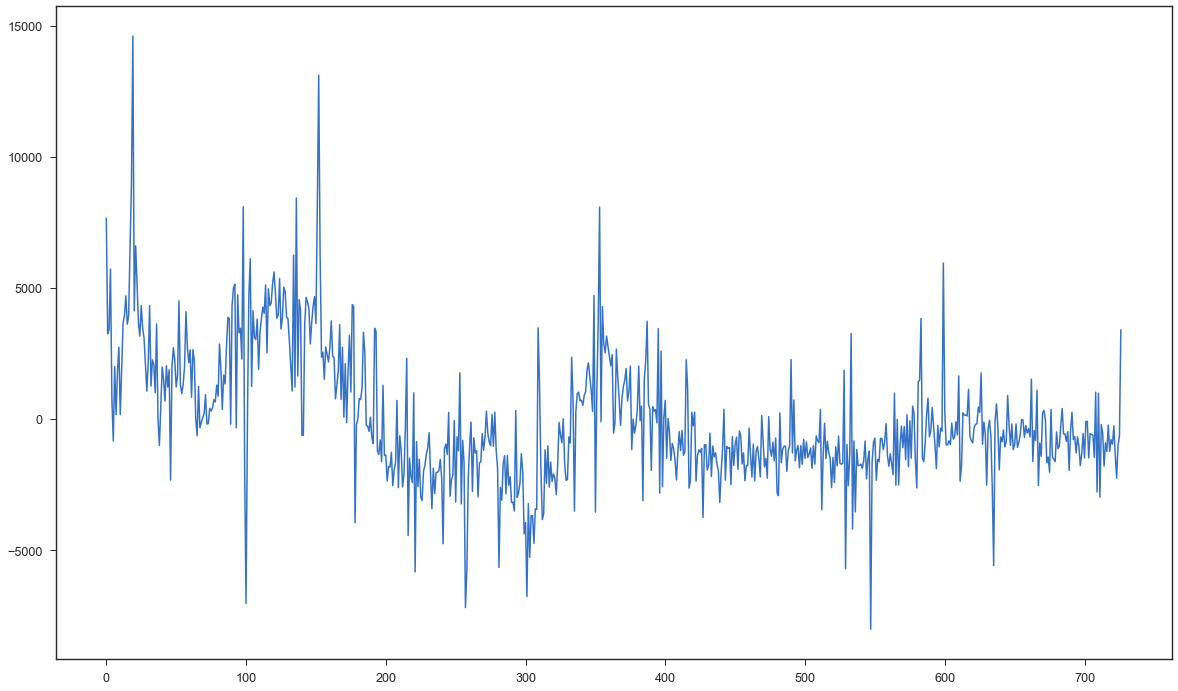

In [40]:
resample = target.resample('W')
weekly_mean = resample.mean()
X = target.values
diff = list()
weeks_in_year = 52
for i in range(weeks_in_year, len(weekly_mean)):
    value = weekly_mean[i] - weekly_mean[i - weeks_in_year]
    diff.append(value)
    
plt.figure(figsize=(20,12))
plt.plot(diff)
plt.show()

2005-12-31    15006.585551
2006-12-31    18070.726027
2007-12-31    19430.156164
2008-12-31    22910.144809
2009-12-31    25243.909589
2010-12-31    23544.915068
2011-12-31    21682.427397
2012-12-31    20450.407104
2013-12-31    21545.917808
2014-12-31    20320.216438
2015-12-31    19070.534247
2016-12-31    17551.633880
2017-12-31    17024.104110
Freq: A-DEC, Name: total_checkouts, dtype: float64


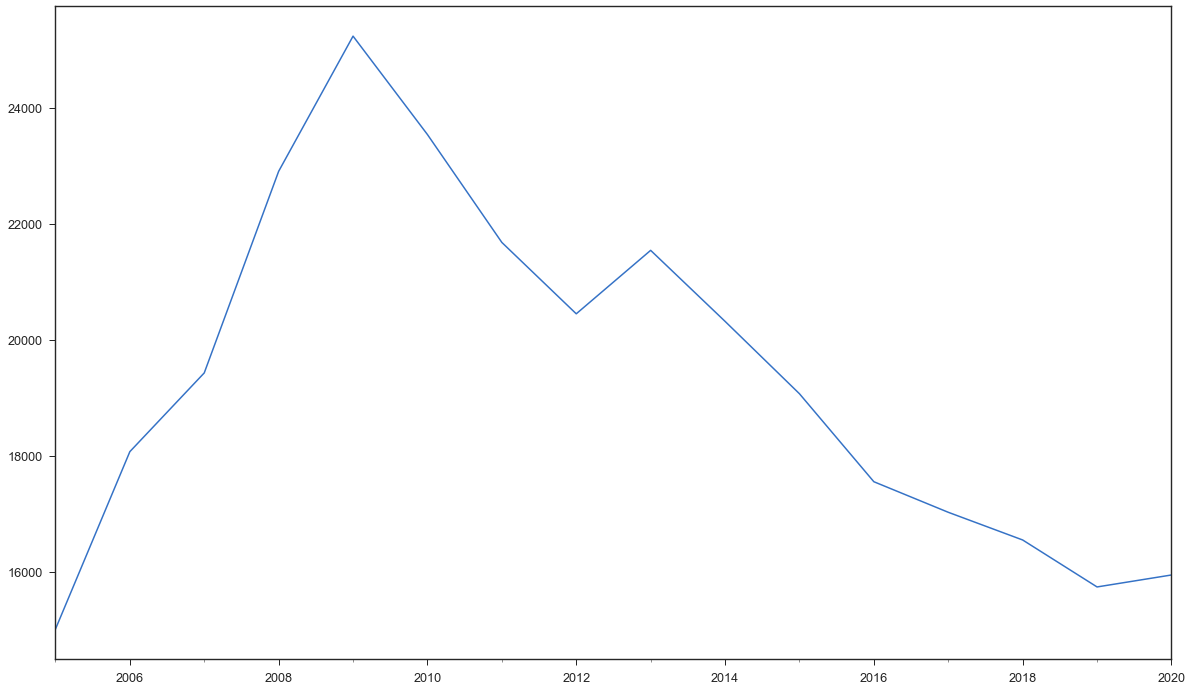

In [41]:
resample = target.resample('Y')
weekly_mean = resample.mean()
print(weekly_mean.head(13))

plt.figure(figsize=(20,12))
weekly_mean.plot()
plt.show()

## Train-test split

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

In [42]:
# 4281 days, or ~78.6% of the data
train_ts = df_imputed.total_checkouts[:'2016-12-31']

# 1167 days, or ~21.4% of the data
test_ts = df_imputed.total_checkouts['2017-01-01':'2020-03-12']

## Dummy model

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

In [43]:
arima = ARIMA(train_ts, order=(0,0,0))
results = arima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        total_checkouts   No. Observations:                 4281
Model:                          ARIMA   Log Likelihood              -59633.246
Date:                Thu, 25 Feb 2021   AIC                         119270.492
Time:                        16:29:31   BIC                         119283.216
Sample:                    04-13-2005   HQIC                        119274.987
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.053e+04   4.47e+05      0.046      0.963   -8.56e+05    8.97e+05
sigma2          2e+11   6.11e+09     32.707      0.000    1.88e+11    2.12e+11
===================================================================================
Ljung-Box (Q):                     9567.12   Jarque-Bera (JB):               564.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

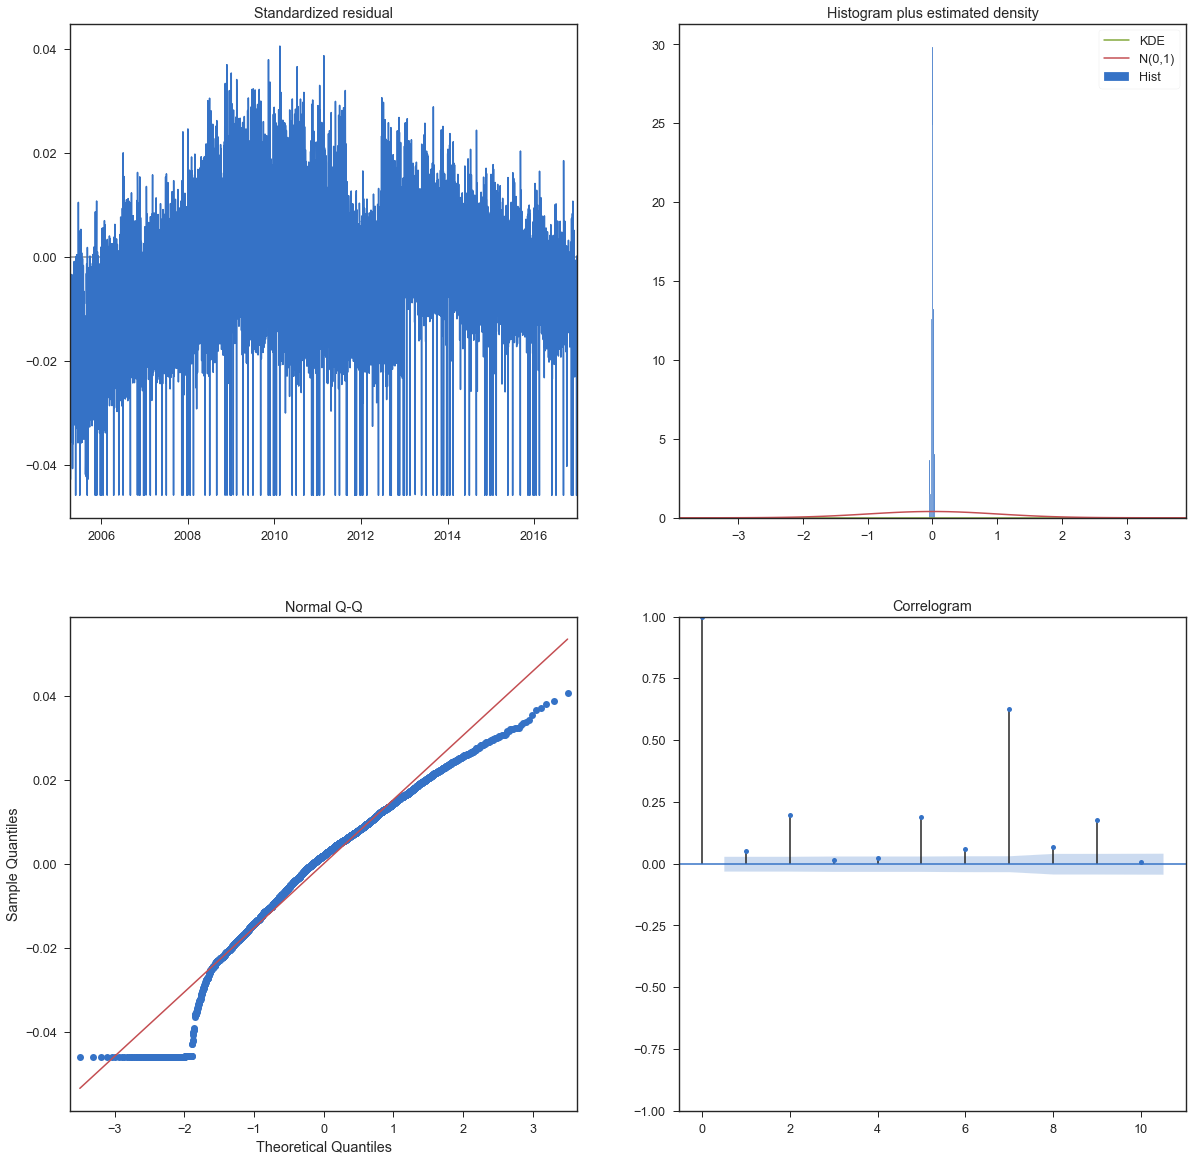

In [44]:
results.plot_diagnostics(figsize = (20,20));

In [45]:
target.head()

2005-04-13    16471.0
2005-04-14    10358.0
2005-04-15    12896.0
2005-04-16     1358.0
2005-04-17     4555.0
Freq: D, Name: total_checkouts, dtype: float64

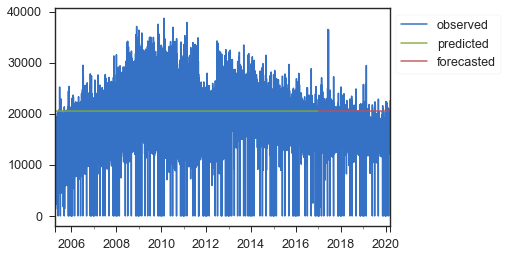

In [46]:
#get predictions

pred = results.get_prediction(start=pd.to_datetime('2005-04-13'),dynamic=True,full_results=True)
pred_conf = pred.conf_int()

forecast = results.get_forecast(steps=len(test_ts))
for_conf = forecast.conf_int()

ax = target.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='predicted',alpha=0.9)
forecast.predicted_mean.plot(ax=ax, label='forecasted', alpha=0.9)


plt.legend(bbox_to_anchor=(1,1), loc="upper left");

In [47]:
forecast.predicted_mean

2017-01-01    20530.788367
2017-01-02    20530.788367
2017-01-03    20530.788367
2017-01-04    20530.788367
2017-01-05    20530.788367
                  ...     
2020-03-08    20530.788367
2020-03-09    20530.788367
2020-03-10    20530.788367
2020-03-11    20530.788367
2020-03-12    20530.788367
Freq: D, Length: 1167, dtype: float64

In [48]:
print('Train:')
print(f'RMSE: {np.sqrt(mean_squared_error(train_ts, pred.predicted_mean))}')
print(f'MAE: {mean_absolute_error(train_ts, pred.predicted_mean)}')
print('')
print('Test: ')
print(f'RMSE: {np.sqrt(mean_squared_error(test_ts, forecast.predicted_mean))}')
print(f'MAE: {mean_absolute_error(test_ts, forecast.predicted_mean)}')

Train:
RMSE: 6834.376710282171
MAE: 5269.344435992415

Test: 
RMSE: 6017.3008306283
MAE: 4578.109856489102


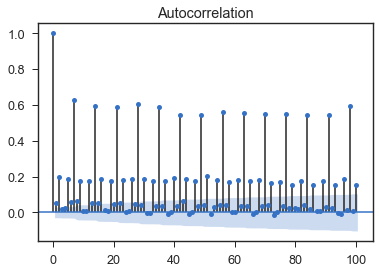

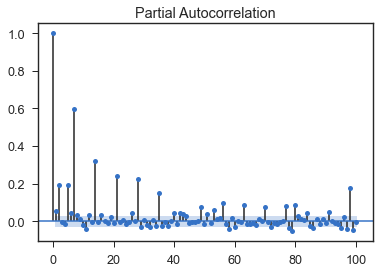

In [49]:
plot_acf(train_ts, lags=100);
plot_pacf(train_ts, lags=100);

## SARIMAX

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

In [50]:
%%time

np.random.seed(7)

#Generate combinations of the number of AR(p), MA(q), and Differencing (d) terms
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))

#Generate combinations of seasonal AR(p), MA(q), and Differencing (d) terms
pdqs = [(x[0], x[1], x[2], 7) for x in pdq] 
count = 1

status_update('Begin loop!')

##grid search parameters using generated list of combinations
models=[]
for comb in pdq:
    for combs in pdqs:
        try:
            #try model
            sarimax = SARIMAX(target, order=comb, seasonal_order=combs,
                              enforce_invertibility=False,enforce_stationarity=False)
            model = sarimax.fit()
#             arima.fit()
            
            #append results to list
            models.append([comb,combs,model.aic])
            count += 1
            if not count % 50:
                status_update(f'{count} models complete!')
        except:
            continue #skip order combination if error

#create data frame of model performance from list and sort by best AIC values
models_df = pd.DataFrame(models, columns=['pdq', 'pdqs', 'aic'])
models_df.sort_values('aic').head(20)

Current time = 16:31:05
-----------------------
Begin loop!

Current time = 16:33:42
-----------------------
50 models complete!

Current time = 16:38:53
-----------------------
100 models complete!

Current time = 16:45:49
-----------------------
150 models complete!

Current time = 16:54:09
-----------------------
200 models complete!

Current time = 17:10:05
-----------------------
250 models complete!

Current time = 17:17:18
-----------------------
300 models complete!

Current time = 17:25:19
-----------------------
350 models complete!

Current time = 17:37:48
-----------------------
400 models complete!

Current time = 17:47:08
-----------------------
450 models complete!

Current time = 18:08:16
-----------------------
500 models complete!

Current time = 18:17:20
-----------------------
550 models complete!

Current time = 18:27:01
-----------------------
600 models complete!

Current time = 18:46:17
-----------------------
650 models complete!

Current time = 18:56:59
------

pdq          pdqs            aic
14   (0, 0, 0)  (1, 1, 2, 7)  106402.393410
23   (0, 0, 0)  (2, 1, 2, 7)  106403.218987
5    (0, 0, 0)  (0, 1, 2, 7)  106501.661636
22   (0, 0, 0)  (2, 1, 1, 7)  106534.925854
20   (0, 0, 0)  (2, 0, 2, 7)  106597.156513
67   (0, 0, 2)  (1, 1, 1, 7)  106614.799181
58   (0, 0, 2)  (0, 1, 1, 7)  106645.767713
31   (0, 0, 1)  (0, 1, 1, 7)  106674.901909
11   (0, 0, 0)  (1, 0, 2, 7)  106683.678961
13   (0, 0, 0)  (1, 1, 1, 7)  106696.780064
19   (0, 0, 0)  (2, 0, 1, 7)  106723.324174
4    (0, 0, 0)  (0, 1, 1, 7)  106723.834266
26   (0, 0, 0)  (2, 2, 2, 7)  106797.228785
17   (0, 0, 0)  (1, 2, 2, 7)  106874.290662
10   (0, 0, 0)  (1, 0, 1, 7)  106927.113213
554  (2, 0, 2)  (1, 1, 2, 7)  106966.540103
311  (1, 0, 2)  (1, 1, 2, 7)  106978.275085
320  (1, 0, 2)  (2, 1, 2, 7)  106979.241803
563  (2, 0, 2)  (2, 1, 2, 7)  106979.618822
545  (2, 0, 2)  (0, 1, 2, 7)  106981.548572

In [152]:
len(df_imputed[:'2020-03-12']) * 0.8, len(df_imputed[:'2020-03-12']) * 0.2

(4358.400000000001, 1089.6000000000001)

In [153]:
(len(df_imputed[:'2020-03-12']) * 0.8)/365.25, (len(df_imputed[:'2020-03-12']) * 0.2)/365.25

(11.932648870636552, 2.983162217659138)

In [154]:
len(df_imputed[:'2016-12-31']), len(df_imputed['2017-01-01':'2020-03-12'])

(4281, 1167)

In [156]:
4281/(4281+1167)

0.7857929515418502

In [157]:
1167/(4281+1167)

0.21420704845814978

# GRAVEYARD

[[go back to the top](#Library-Usage-in-Seattle,-2005-2020)]

In [23]:
for year in range(2005, 2021):
    df_test = adfuller(target[str(year)])
    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(str(year))
    print(dfoutput)
    print('-' * 50)

2005
Test Statistic                  -2.357092
p-value                          0.154215
#Lags Used                      13.000000
Number of Observations Used    249.000000
dtype: float64
--------------------------------------------------
2006
Test Statistic                  -2.492733
p-value                          0.117252
#Lags Used                      15.000000
Number of Observations Used    349.000000
dtype: float64
--------------------------------------------------
2007
Test Statistic                  -3.967524
p-value                          0.001590
#Lags Used                      13.000000
Number of Observations Used    351.000000
dtype: float64
--------------------------------------------------
2008
Test Statistic                  -3.797025
p-value                          0.002938
#Lags Used                      13.000000
Number of Observations Used    352.000000
dtype: float64
--------------------------------------------------
2009
Test Statistic                  -2.9596

In [21]:
# subset target data
target = df_imputed.total_checkouts[:'2020-03-12']
X = target.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=21022.584435, mean2=18271.298458
variance1=54498466.225984, variance2=29073096.868705


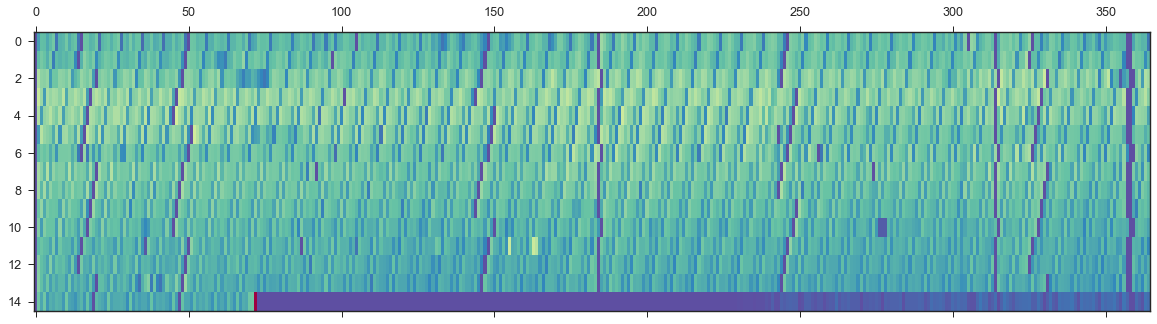

In [126]:
# Transpose the yearly group DataFrame
year_matrix = checkouts_annual.T
# Draw a heatmap with matshow()
plt.figure(figsize=(20,5))
plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r, fignum=1)
plt.show()

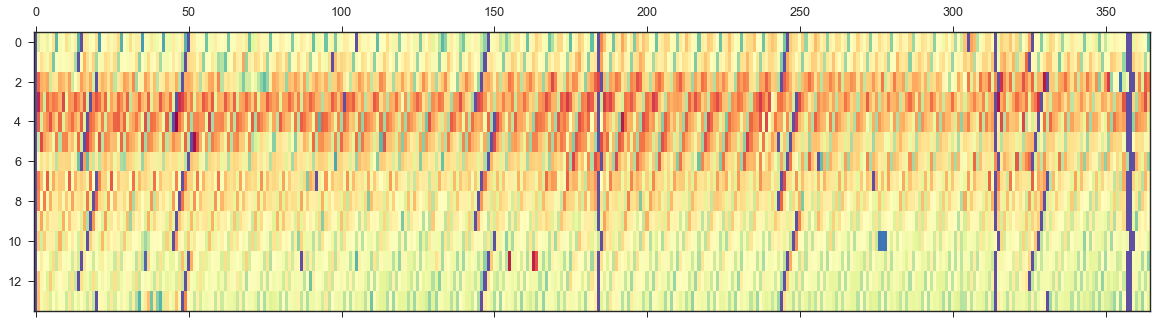

In [135]:
# Transpose the yearly group DataFrame
year_matrix = checkouts_annual[range(2006,2020)].T
# Draw a heatmap with matshow()
plt.figure(figsize=(20,5))
plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r, fignum=1)
plt.show()

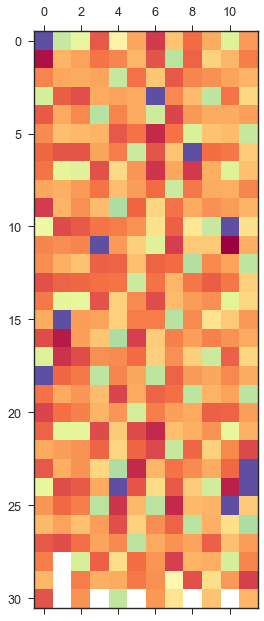

In [141]:
# Draw a heatmap comparing the months of the year in 1990 
plt.matshow(months_df, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.show()

## Autocorrelation

#### What is autocorrleation? 

It is the correlation between one time series and the same time series shifted by k periods. 

In [72]:
checkouts_lag_1 = target['2010-01-01':'2010-12-31'].shift(periods=1)
checkouts_lag_2 = target['2010-01-01':'2010-12-31'].shift(periods=2)
checkouts_lag_3 = target['2010-01-01':'2010-12-31'].shift(periods=3)

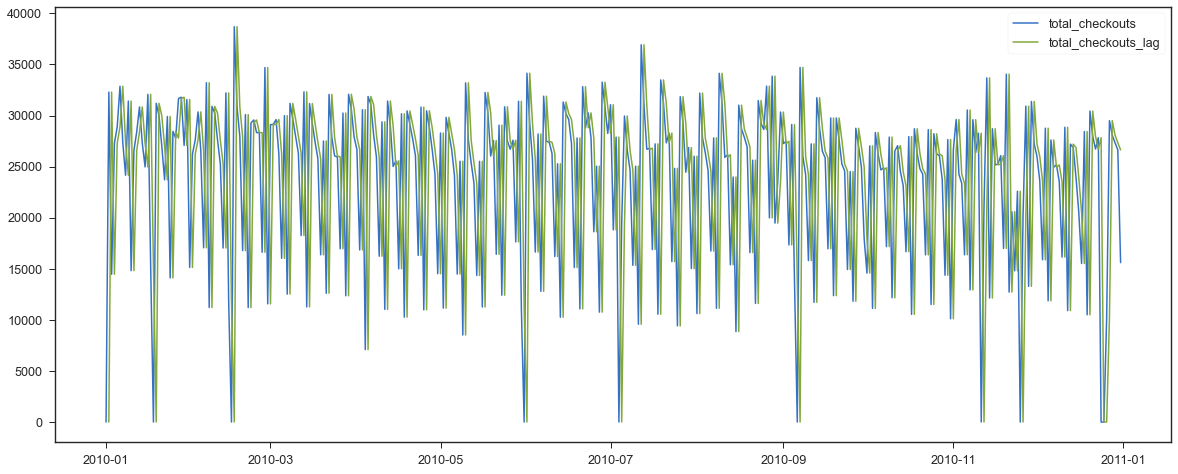

In [75]:
plt.figure(figsize=(20,8))
plt.plot(target['2010-01-01':'2010-12-31'])
plt.plot(checkouts_lag_1)
plt.legend(['total_checkouts', 'total_checkouts_lag']);

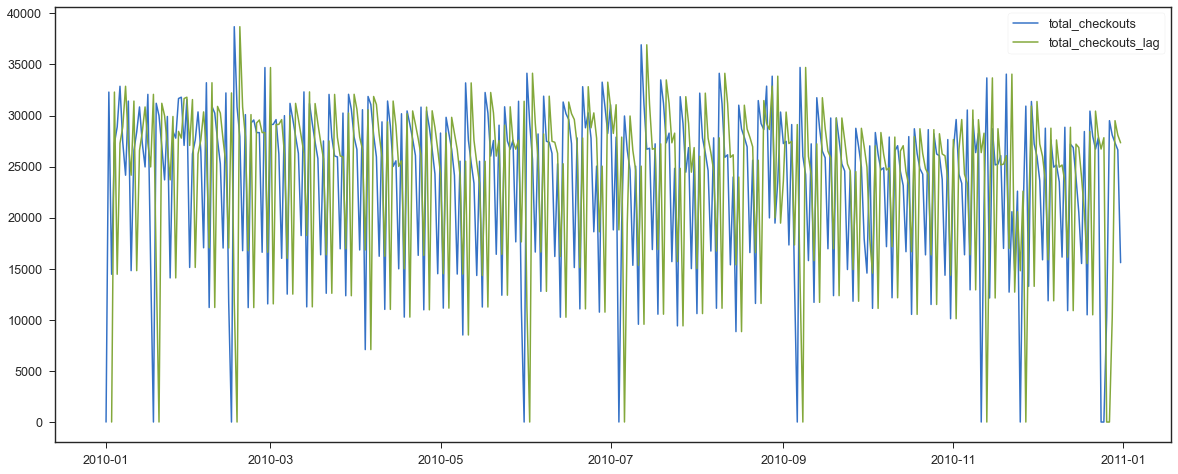

In [76]:
plt.figure(figsize=(20,8))
plt.plot(target['2010-01-01':'2010-12-31'])
plt.plot(checkouts_lag_2)
plt.legend(['total_checkouts', 'total_checkouts_lag']);

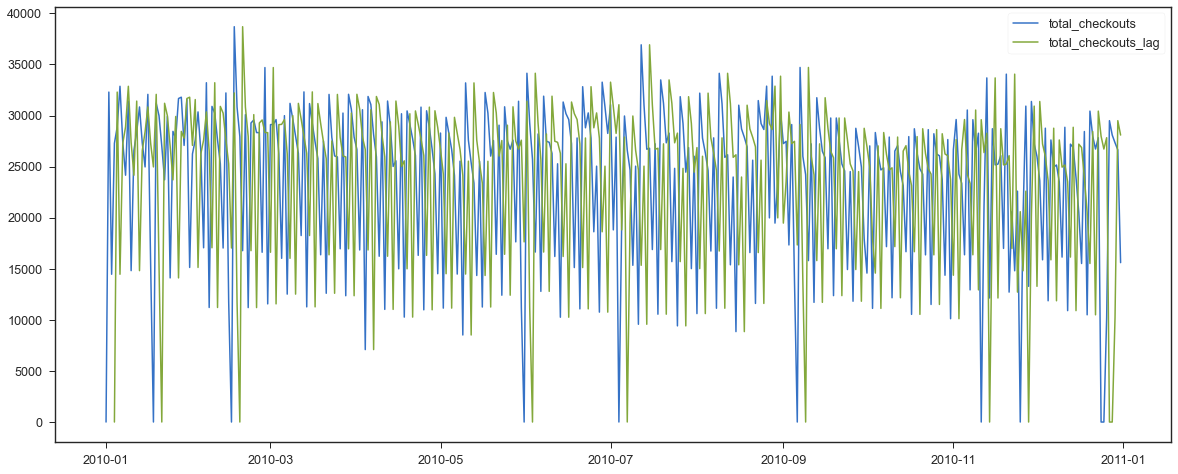

In [77]:
plt.figure(figsize=(20,8))
plt.plot(target['2010-01-01':'2010-12-31'])
plt.plot(checkouts_lag_3)
plt.legend(['total_checkouts', 'total_checkouts_lag']);